<a href="https://colab.research.google.com/github/martell-n-tardy/London-Housing-Case-Study/blob/master/Rently_London_Housing_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **(Hypothetical) Rently - London Market**

## Contents


1. Introduction 
2. Sourcing and Loading
3. Cleaning, Transforming, and Visualizing
4. Modeling
5. Conclusion












## 1. Introduction

Here’s the problem we’re going to solve for Rently: 

> **Using historical sales data, from the London housing market, which boroughs of London have seen the greatest increase in housing prices, on average, over the last two decades?**

NOTE: *A borough is just a fancy word for district. You may be familiar with the five boroughs of New York… well, there are 32 boroughs within Greater London [(here's some info for the curious)](https://en.wikipedia.org/wiki/London_boroughs).

## 2. Sourcing and Loading 

### 2.1. Importing libraries

In [1]:
#Import necessary libaries and rename 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

### 2.2.  Loading data
The data used comes from the [London Datastore](https://data.london.gov.uk/): a free, open-source data-sharing portal for London-oriented datasets. 

In [2]:
#Assign URL link to a vaiable
url_LondonHousePrices = "https://data.london.gov.uk/download/uk-house-price-index/70ac0766-8902-4eb5-aab5-01951aaed773/UK%20House%20price%20index.xls"

#The dataset we're interested in contains the Average prices of the houses, and is actually on a particular sheet of the Excel file. 
#As a result, we need to specify the sheet name in the read_excel() method.
#We will put this data into a variable called properties.  
properties = pd.read_excel(url_LondonHousePrices, sheet_name='Average price', index_col= None)

## 3. Cleaning, Transforming, and Visualizing


### 3.1. Exploring the data

In [3]:
properties.shape

(322, 49)

The shape indicates that there are 49 columns. However, there are only 32 boroughs in London. This suggests that some of the columns in the dataframe are not boroughs. Let's explore the data further.

In [4]:
properties.head()

,Unnamed: 0,City of London,Barking & Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith & Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington & Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Unnamed: 34,Inner London,Outer London,Unnamed: 37,NORTH EAST,NORTH WEST,YORKS & THE HUMBER,EAST MIDLANDS,WEST MIDLANDS,EAST OF ENGLAND,LONDON,SOUTH EAST,SOUTH WEST,Unnamed: 47,England
0,NaT,E09000001,E09000002,E09000003,E09000004,E09000005,E09000006,E09000007,E09000008,E09000009,E09000010,E09000011,E09000012,E09000013,E09000014,E09000015,E09000016,E09000017,E09000018,E09000019,E09000020,E09000021,E09000022,E09000023,E09000024,E09000025,E09000026,E09000027,E09000028,E09000029,E09000030,E09000031,E09000032,E09000033,NaN,E13000001,E13000002,NaN,E12000001,E12000002,E12000003,E12000004,E12000005,E12000006,E12000007,E12000008,E12000009,NaN,E92000001
1,1995-01-01,91449,50460.2,93284.5,64958.1,71306.6,81671.5,120933,69158.2,79885.9,72514.7,62300.1,61296.5,124903,76287.6,84769.5,68000.1,73834.8,72231.7,92516.5,182695,80875.8,67771,60491.3,82070.6,53539.3,72189.6,109326,67885.2,71537,59865.2,61319.4,88559,133025,NaN,78252,72958.8,NaN,42076.4,43958.5,44803.4,45544.5,48527.5,56701.6,74435.8,64018.9,54705.2,NaN,53202.8
2,1995-02-01,82202.8,51085.8,93190.2,64787.9,72022.3,81657.6,119509,68951.1,80897.1,73155.2,60993.3,63187.1,122088,78901.2,83396.1,69393.5,75031.1,71051.6,94342.4,182345,81230.1,65381.5,60869.3,79982.7,53153.9,72141.6,111103,64799.1,70893.2,62318.5,60252.1,88641,131468,NaN,75885.7,72937.9,NaN,42572,43925.4,44528.8,46051.6,49341.3,56593.6,72777.9,63715,54356.1,NaN,53096.2
3,1995-03-01,79120.7,51269,92247.5,64367.5,72015.8,81449.3,120282,68712.4,81379.9,72190.4,61377.8,63593.3,120636,78521.9,83416.2,69368,74188.7,72098,93465.9,182879,81111.5,66336.5,60288,80661.7,53458.3,72501.4,107325,65763.3,70306.8,63938.7,60871.1,87124.8,132260,NaN,76591.6,72714.5,NaN,42369.7,44434.9,45200.5,45383.8,49442.2,56171.2,73896.8,64113.6,53583.1,NaN,53201.3
4,1995-04-01,77101.2,53133.5,90762.9,64277.7,72965.6,81124.4,120098,68610,82188.9,71442.9,61927.7,65139.6,121425,79545.6,83567.9,69444.3,73911.4,71890.3,93344.5,184177,81672.8,66388.8,59471,79990.5,54479.8,72228.6,106875,63073.6,69411.9,66233.2,60971.4,87026,133370,NaN,76851.6,72591.9,NaN,42095.8,44267.8,45614.3,46124.2,49455.9,56567.9,74455.3,64623.2,54786,NaN,53590.9


In [5]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            321 non-null    datetime64[ns]
 1   City of London        322 non-null    object        
 2   Barking & Dagenham    322 non-null    object        
 3   Barnet                322 non-null    object        
 4   Bexley                322 non-null    object        
 5   Brent                 322 non-null    object        
 6   Bromley               322 non-null    object        
 7   Camden                322 non-null    object        
 8   Croydon               322 non-null    object        
 9   Ealing                322 non-null    object        
 10  Enfield               322 non-null    object        
 11  Greenwich             322 non-null    object        
 12  Hackney               322 non-null    object        
 13  Hammersmith & Fulham

There are three columns that are Unnamed and have no data (i.e. all the values in the column are null). These columns can be removed right away, as it is clear that they aren't boroughs.

### 3.2. Cleaning the data

In [6]:
#identify columns that start with Unnamed and contain only nulls
unnamed_cols = [col for col in properties if col.startswith('Unnamed: ') and properties[col].isna().sum() == len(properties)]

#drop Unnamed columns with nulls from the dataframe
properties_named = properties.drop(columns=unnamed_cols)
properties_named.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            321 non-null    datetime64[ns]
 1   City of London        322 non-null    object        
 2   Barking & Dagenham    322 non-null    object        
 3   Barnet                322 non-null    object        
 4   Bexley                322 non-null    object        
 5   Brent                 322 non-null    object        
 6   Bromley               322 non-null    object        
 7   Camden                322 non-null    object        
 8   Croydon               322 non-null    object        
 9   Ealing                322 non-null    object        
 10  Enfield               322 non-null    object        
 11  Greenwich             322 non-null    object        
 12  Hackney               322 non-null    object        
 13  Hammersmith & Fulham

After dropping the Unnamed columns, there are 46 remaining columns in the dataframe, indicating that there are still columns listed that are not boroughs.

In [7]:
# Define tuple of valid London Boroughs (including City of London)
London_Borough = (
"City of London",
"Westminster",
"Kensington & Chelsea",
"Hammersmith & Fulham",
"Wandsworth",
"Lambeth",
"Southwark",
"Tower Hamlets",
"Hackney",
"Islington",
"Camden",
"Brent",
"Ealing",
"Hounslow",
"Richmond upon Thames",
"Kingston upon Thames",
"Merton",
"Sutton",
"Croydon",
"Bromley",
"Lewisham",
"Greenwich",
"Bexley",
"Havering",
"Barking & Dagenham",
"Redbridge",
"Newham",
"Waltham Forest",
"Haringey",
"Enfield",
"Barnet",
"Harrow",
"Hillingdon")

# Find columns that aren't in LONDON_BOROUGHS
is_not_borough = np.isin(properties_named.columns,London_Borough,invert=True)
cols_not_borough = properties_named.columns[is_not_borough]
print(cols_not_borough)

Index(['Unnamed: 0', 'Inner London', 'Outer London', 'NORTH EAST',
       'NORTH WEST', 'YORKS & THE HUMBER', 'EAST MIDLANDS', 'WEST MIDLANDS',
       'EAST OF ENGLAND', 'LONDON', 'SOUTH EAST', 'SOUTH WEST', 'England'],
      dtype='object')


Unnamed: 0 is a valid column and should be kept in the dataframe. The other columns listed can be removed as they are not valid boroughs.

In [8]:
#create a new dataframe called properties_LB that only contains valid London Boroughs
#note: Element 0 is a valid column even though it's not a borough, so it's retained.
properties_LB = properties_named.drop(columns=cols_not_borough[1:])
properties_LB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            321 non-null    datetime64[ns]
 1   City of London        322 non-null    object        
 2   Barking & Dagenham    322 non-null    object        
 3   Barnet                322 non-null    object        
 4   Bexley                322 non-null    object        
 5   Brent                 322 non-null    object        
 6   Bromley               322 non-null    object        
 7   Camden                322 non-null    object        
 8   Croydon               322 non-null    object        
 9   Ealing                322 non-null    object        
 10  Enfield               322 non-null    object        
 11  Greenwich             322 non-null    object        
 12  Hackney               322 non-null    object        
 13  Hammersmith & Fulham

Now, let's transpose the dataframe so that each variable corresponds to a borrough and not the date.

In [9]:
#transpose dataset
properties_T = properties_LB.T
properties_T.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321
Unnamed: 0,NaT,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00
City of London,E09000001,91449,82202.8,79120.7,77101.2,84409.1,94900.5,110128,112329,104473,108038,117636,127232,108999,93356.7,93706.7,120543,112050,114226,97546.7,114179,108138,98934.2,99706.8,106427,116343,111142,107488,108480,115453,118317,117034,113585,115159,121251,131074,130035,124382,143829,156508,...,789278,809697,784144,800875,802869,764207,811694,865636,894520,853451,738797,719218,761526,756407,813770,810455,826227,772325,757730,773786,800016,836241,920444,918209,882872,786627,827659,798499,836807,769392,801999,754194,725011,719703,728497,720954,729879,-,-,-
Barking & Dagenham,E09000002,50460.2,51085.8,51269,53133.5,53042.2,53700.3,52113.1,52232.2,51471.6,51513.8,50848.7,50945.2,50828.1,51440.7,51907.1,51724,51735.7,50761.4,50621.1,51104.7,51892.7,52533.2,52216,53853.5,54459,55451.5,55004.8,55279.9,54936.9,55286.7,55658.9,56506.7,56306.3,57200.2,57575.3,58025,57559,57360.3,57908.5,...,294236,294953,295908,296424,299648,302606,301114,297181,293839,294065,295498,295092,293889,297426,299421,304778,304579,304515,299771,303055,302697,301413,293603,293816,300526,304556,304924,301702,304852,305012,309560,312470,315749,312382,313131,312431,317235,319550,322496,329287
Barnet,E09000003,93284.5,93190.2,92247.5,90762.9,90258,90107.2,91441.2,92361.3,93273.1,92567.4,90883.2,91133.9,91111,92429.5,91409.8,92394.2,91058.9,91978.2,92444.1,95516,97489.9,97844.5,97155,97174.3,98558.8,100076,101130,101201,103287,104609,107235,108730,112380,114515,115356,115521,115902,116995,118866,...,524702,523397,533715,534951,537284,535060,533810,528639,523679,516531,512343,503911,512694,514668,528577,526670,525678,530343,522552,521434,516660,522115,526689,526033,518175,523280,529660,533619,530354,528816,532528,538684,537171,537973,530778,533319,541297,536013,544559,533093
Bexley,E09000004,64958.1,64787.9,64367.5,64277.7,63997.1,64252.3,63722.7,64432.6,64509.5,64529.9,63846,63816.9,63996,64503.7,64788,65285.9,65080.7,65119.8,65150.6,65960.2,66500.6,66659.3,66353.8,66486.4,67350.6,67981.2,67823.8,68470.5,69353.5,70764.1,71129.8,72140.7,72830.3,73378.8,73619.6,74630.1,76863.5,78064.9,79062.3,...,341480,345693,34753

In [10]:
#confirm what our row indices are
properties_T.index

Index(['Unnamed: 0', 'City of London', 'Barking & Dagenham', 'Barnet',
       'Bexley', 'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith & Fulham', 'Haringey', 'Harrow',
       'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington & Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham',
       'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark',
       'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth',
       'Westminster'],
      dtype='object')

In [11]:
#reset the indices, and the reassign the result
properties_T = properties_T.reset_index()
properties_T.index

RangeIndex(start=0, stop=34, step=1)

In [12]:
#confirm that the first row contains the proper values for column headings
properties_T.iloc[[0]]

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321
0,Unnamed: 0,NaT,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00


In [13]:
#reassign the columns at index 0
properties_T.columns = properties_T.iloc[0]
properties_T.head()

,Unnamed: 0,NaN,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00
0,Unnamed: 0,NaT,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00
1,City of London,E09000001,91449,82202.8,79120.7,77101.2,84409.1,94900.5,110128,112329,104473,108038,117636,127232,108999,93356.7,93706.7,120543,112050,114226,97546.7,114179,108138,98934.2,99706.8,106427,116343,111142,107488,108480,115453,118317,117034,113585,115159,121251,131074,130035,124382,143829,...,789278,809697,784144,800875,802869,764207,811694,865636,894520,853451,738797,719218,761526,756407,813770,810455,826227,772325,757730,773786,800016,836241,920444,918209,882872,786627,827659,798499,836807,769392,801999,754194,725011,719703,728497,720954,729879,-,-,-
2,Barking & Dagenham,E09000002,50460.2,51085.8,51269,53133.5,53042.2,53700.3,52113.1,52232.2,51471.6,51513.8,50848.7,50945.2,50828.1,51440.7,51907.1,51724,51735.7,50761.4,50621.1,51104.7,51892.7,52533.2,52216,53853.5,54459,55451.5,55004.8,55279.9,54936.9,55286.7,55658

In [14]:
#drop the row at index 0
properties_T = properties_T.drop(0)
properties_T.head()

,Unnamed: 0,NaN,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00
1,City of London,E09000001,91449,82202.8,79120.7,77101.2,84409.1,94900.5,110128,112329,104473,108038,117636,127232,108999,93356.7,93706.7,120543,112050,114226,97546.7,114179,108138,98934.2,99706.8,106427,116343,111142,107488,108480,115453,118317,117034,113585,115159,121251,131074,130035,124382,143829,...,789278,809697,784144,800875,802869,764207,811694,865636,894520,853451,738797,719218,761526,756407,813770,810455,826227,772325,757730,773786,800016,836241,920444,918209,882872,786627,827659,798499,836807,769392,801999,754194,725011,719703,728497,720954,729879,-,-,-
2,Barking & Dagenham,E09000002,50460.2,51085.8,51269,53133.5,53042.2,53700.3,52113.1,52232.2,51471.6,51513.8,50848.7,50945.2,50828.1,51440.7,51907.1,51724,51735.7,50761.4,50621.1,51104.7,51892.7,52533.2,52216,53853.5,54459,55451.5,55004.8,55279.9,54936.9,55286.7,55658.9,56506.7,56306.3,57200.2,57575.3,58025,57559,57360.3,...,294236,294953,295908,296424,299648,302606,301114,297181,293839,294065,295498,295092,293889,297426,299421,304778,304579,304515,299771,303055,302697,301413,293603,293816,300526,304556,304924,301702,304852,305012,309560,312470,315749,312382,313131,312431,317235,319550,322496,329287
3,Barnet,E09000003,93284.5,93190.2,92247.5,90762.9,90258,90107.2,91441.2,92361.3,93273.1,92567.4,90883.2,91133.9,91111,92429.5,91409.8,92394.2,91058.9,91978.2,92444.1,95516,97489.9,97844.5,97155,97174.3,98558.8,100076,101130,101201,103287,104609,107235,108730,112380,114515,115356,115521,115902,116995,...,524702,523397,533715,534951,537284,535060,533810,528639,523679,516531,512343,503911,512694,514668,528577,526670,525678,530343,522552,521434,516660,522115,526689,526033,518175,523280,529660,533619,530354,528816,532528,538684,537171,537973,530778,533319,541297,536013,544559,533093
4,Bexley,E09000004,64958.1,64787.9,64367.5,64277.7,63997.1,64252.3,63722.7,64432.6,64509.5,64529.9,63846,63816.9,63996,64503.7,64788,65285.9,65080.7,65119.8,65150.6,65960.2,66500.6,66659.3,66353.8,66486.4,67350.6,67981.2,67823.8,68470.5,69353.5,70764.1,71129.8,72140.7,72830.3,73378.8,73619.6,74630.1,76863.5,78064.9,...,341480,345693,347531,346151,344681,344172,343667,338708,339186,336680,339330,336981,339324,338346,337523,333340,332920,333170,338347,336780,339026,339182,341553,339353,340893,344091,346680,345061,345405,346253,352261,355757,359324,361782,362053,361919,364464,366452,373547,375156
5,Brent,E09000005,71306.6,72022.3,72015.8,72965.6,73704

In [15]:
#rename columns: 'Unnamed: 0' and 'NaN' using a dict
properties_T = properties_T.rename(columns = {'Unnamed: 0':'London_Borough', pd.NaT: 'ID'})
properties_T.head()

,London_Borough,ID,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00
1,City of London,E09000001,91449,82202.8,79120.7,77101.2,84409.1,94900.5,110128,112329,104473,108038,117636,127232,108999,93356.7,93706.7,120543,112050,114226,97546.7,114179,108138,98934.2,99706.8,106427,116343,111142,107488,108480,115453,118317,117034,113585,115159,121251,131074,130035,124382,143829,...,789278,809697,784144,800875,802869,764207,811694,865636,894520,853451,738797,719218,761526,756407,813770,810455,826227,772325,757730,773786,800016,836241,920444,918209,882872,786627,827659,798499,836807,769392,801999,754194,725011,719703,728497,720954,729879,-,-,-
2,Barking & Dagenham,E09000002,50460.2,51085.8,51269,53133.5,53042.2,53700.3,52113.1,52232.2,51471.6,51513.8,50848.7,50945.2,50828.1,51440.7,51907.1,51724,51735.7,50761.4,50621.1,51104.7,51892.7,52533.2,52216,53853.5,54459,55451.5,55004.8,55279.9,54936.9,55286.7,55658.9,56506.7,56306.3,57200.2,57575.3,58025,57559,57360.3,...,294236,294953,295908,296424,299648,302606,301114,297181,293839,294065,295498,295092,293889,297426,299421,304778,304579,304515,299771,303055,302697,301413,293603,293816,300526,304556,304924,301702,304852,305012,309560,312470,315749,312382,313131,312431,317235,319550,322496,329287
3,Barnet,E09000003,93284.5,93190.2,92247.5,90762.9,90258,90107.2,91441.2,92361.3,93273.1,92567.4,90883.2,91133.9,91111,92429.5,91409.8,92394.2,91058.9,91978.2,92444.1,95516,97489.9,97844.5,97155,97174.3,98558.8,100076,101130,101201,103287,104609,107235,108730,112380,114515,115356,115521,115902,116995,...,524702,523397,533715,534951,537284,535060,533810,528639,523679,516531,512343,503911,512694,514668,528577,526670,525678,530343,522552,521434,516660,522115,526689,526033,518175,523280,529660,533619,530354,528816,532528,538684,537171,537973,530778,533319,541297,536013,544559,533093
4,Bexley,E09000004,64958.1,64787.9,64367.5,64277.7,63997.1,64252.3,63722.7,64432.6,64509.5,64529.9,63846,63816.9,63996,64503.7,64788,65285.9,65080.7,65119.8,65150.6,65960.2,66500.6,66659.3,66353.8,66486.4,67350.6,67981.2,67823.8,68470.5,69353.5,70764.1,71129.8,72140.7,72830.3,73378.8,73619.6,74630.1,76863.5,78064.9,...,341480,345693,347531,346151,344681,344172,343667,338708,339186,336680,339330,336981,339324,338346,337523,333340,332920,333170,338347,336780,339026,339182,341553,339353,340893,344091,346680,345061,345405,346253,352261,355757,359324,361782,362053,361919,364464,366452,373547,375156
5,Brent,E09000005,71306.6,72022.3,72015.8,72965.6,73

### 3.3.Transforming the data

In [16]:
#melt column headings into a single column
clean_properties = pd.melt(properties_T, id_vars= ['London_Borough', 'ID'])
clean_properties.head()

,London_Borough,ID,0,value
0,City of London,E09000001,1995-01-01,91449
1,Barking & Dagenham,E09000002,1995-01-01,50460.2
2,Barnet,E09000003,1995-01-01,93284.5
3,Bexley,E09000004,1995-01-01,64958.1
4,Brent,E09000005,1995-01-01,71306.6


In [17]:
#rename columns '0' and 'value'
clean_properties = clean_properties.rename(columns = {0: 'Year-Month', 'value': 'Average_price'})
clean_properties.head()

,London_Borough,ID,Year-Month,Average_price
0,City of London,E09000001,1995-01-01,91449
1,Barking & Dagenham,E09000002,1995-01-01,50460.2
2,Barnet,E09000003,1995-01-01,93284.5
3,Bexley,E09000004,1995-01-01,64958.1
4,Brent,E09000005,1995-01-01,71306.6


In [18]:
#check for any missing values
clean_properties.count()

London_Borough    10593
ID                10593
Year-Month        10593
Average_price     10593
dtype: int64

In [19]:
clean_properties.dtypes

London_Borough            object
ID                        object
Year-Month        datetime64[ns]
Average_price             object
dtype: object

In [20]:
#convert Average_price to float and confirm change
clean_properties['Average_price'] = pd.to_numeric(clean_properties['Average_price'])
clean_properties.dtypes

ValueError: ignored

There is a formatting issue within variable `Average_price`. Let's explore to see what it is.

In [21]:
clean_properties['Average_price'].value_counts()

-               3
501992.0407     1
483335.7786     1
202145.1754     1
254229.1949     1
               ..
273054.1937     1
338589.7583     1
551580.3008     1
625190.02458    1
638976.9817     1
Name: Average_price, Length: 10591, dtype: int64

There appears to be three instances where the value for the variable is " - ".

In [22]:
clean_properties[clean_properties['Average_price']=='-']

,London_Borough,ID,Year-Month,Average_price
10494,City of London,E09000001,2021-07-01,-
10527,City of London,E09000001,2021-08-01,-
10560,City of London,E09000001,2021-09-01,-


In [24]:
#lets examine this borough across 2021 to gain context
clean_properties.loc[(clean_properties['Year-Month'].dt.year == 2021) & (clean_properties['London_Borough']=='City of London')]

,London_Borough,ID,Year-Month,Average_price
10296,City of London,E09000001,2021-01-01,754194
10329,City of London,E09000001,2021-02-01,725011
10362,City of London,E09000001,2021-03-01,719703
10395,City of London,E09000001,2021-04-01,728497
10428,City of London,E09000001,2021-05-01,720954
10461,City of London,E09000001,2021-06-01,729879
10494,City of London,E09000001,2021-07-01,-
10527,City of London,E09000001,2021-08-01,-
10560,City of London,E09000001,2021-09-01,-


After researching online to gain context to the potential value for these missing observations, I found a credible article from [The Week](https://www.theweek.co.uk/london-house-prices). The article states the City of London's housing market in August 2021 was $697411.60 (£522,365) and in September 2021 $$677,235.51 (£507,253).
 
Therefore, since there is a clear downward trend. These numbers, from the article, will be used for August's and September's observations. July's value will be the average of June's and August's values.

In [27]:
#replace "-" in rows 10527 and 10560
clean_properties.iloc[10527,3]= 697411.60
clean_properties.iloc[10560,3]= 677235.51

#replace "-" in row 10494 with avg 
clean_properties.iloc[10494,3]= (729879+697411.60)/2

#confirm entry changed
clean_properties.iloc[[10494,10527,10560],3]

10494    713645
10527    697412
10560    677236
Name: Average_price, dtype: object

Now, let's try again to convert the dtype of `Average_price`.

In [28]:
#convert Average_price to float and confirm change
clean_properties['Average_price'] = pd.to_numeric(clean_properties['Average_price'])
clean_properties.dtypes

London_Borough            object
ID                        object
Year-Month        datetime64[ns]
Average_price            float64
dtype: object

Awesome, the `Average_price` is a floating point now, representing the fact that the observations are numerical in value and not an object.

In [32]:
#confirm all NaN entries are removed and save final clean df
df = clean_properties.dropna()
df.head()

,London_Borough,ID,Year-Month,Average_price
0,City of London,E09000001,1995-01-01,91448.98487
1,Barking & Dagenham,E09000002,1995-01-01,50460.22660
2,Barnet,E09000003,1995-01-01,93284.51832
3,Bexley,E09000004,1995-01-01,64958.09036
4,Brent,E09000005,1995-01-01,71306.56698


###3.4. Visualizing the data

To visualize the data, why not subset on a particular London Borough? Maybe do a line plot of Month against Average Price?

Text(0, 0.5, 'Price')

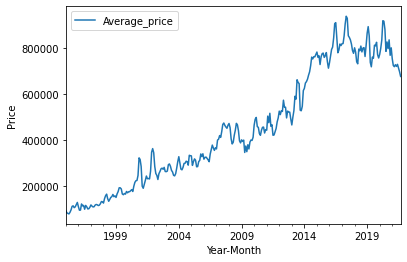

In [40]:
#visualize Camden borough
LON_prices = df[df['London_Borough'] == 'City of London']
#plot parameters for Year-Month and Average_price
ax = LON_prices.plot(kind='line', x = 'Year-Month', y='Average_price')
#label y-axis
ax.set_ylabel('Price')

To limit the number of data points displayed let's extract the year from the `Year-Month` column.

In [34]:
#clarifying the visualization by year
df['Year'] = df['Year-Month'].apply(lambda t: t.year)
df.tail()

,London_Borough,ID,Year-Month,Average_price,Year
10588,Sutton,E09000029,2021-09-01,415227.6650,2021
10589,Tower Hamlets,E09000030,2021-09-01,440846.7361,2021
10590,Waltham Forest,E09000031,2021-09-01,505389.1863,2021
10591,Wandsworth,E09000032,2021-09-01,599124.4127,2021
10592,Westminster,E09000033,2021-09-01,965766.3554,2021


In the MoM (month over month) plot the trend is a clear increase in housing prices until 2009. Then from 2009 through 2010 there was a clear temporary crash in the market until it began to gradually increase again in 2011. Record highs are seen from 2016 until 2020 with a clear decline beginning in 2021.

## 4. Modeling

Now, that dataset is cleaned, transformed, and we've been able to grasp some understanding of it's trends through visuals. Now, it's time to begin answering our objective: **which boroughs of London have seen the greatest house price increase, on average, over the past two decades?**

In [42]:
#calculate the mean house price for each year
dfg = df.groupby(by=['London_Borough', 'Year']).mean()
dfg.sample(10)

Average_price
London_Borough       Year               
Hounslow             1996   73886.734233
Haringey             2010  314479.843742
Wandsworth           2017  617921.475300
Merton               1995   80500.752648
Barnet               1999  136004.512067
Camden               2002  314179.507833
                     2019  843066.936333
Hammersmith & Fulham 2012  567081.840458
Redbridge            1998   94514.395822
                     2013  274824.944308

In [43]:
dfg = dfg.reset_index()
dfg.head()

,London_Borough,Year,Average_price
0,Barking & Dagenham,1995,51817.969390
1,Barking & Dagenham,1996,51718.192690
2,Barking & Dagenham,1997,55974.262309
3,Barking & Dagenham,1998,60285.821083
4,Barking & Dagenham,1999,65320.934441


Now, let's create a function that will calculate a ratio of house prices, comparing the price of a house in 2021 to the price in 1995.

The function will be called `create_price_ratio`.

This function will do the following:
1. Take a filter of dfg, specifically where this filter constrains the `London_Borough`, as an argument.
2. Get the `Average_price` for that Borough, for the years 1995 and 2021.
4. Calculate the ratio of the `Average_price` for 1995 divided by the `Average_price` for 2021.
5. Return that ratio.

Ultimately, this function will iterate through all the unique London_Boroughs and work out the ratio capturing the difference of house prices between 1995 and 2021.

In [54]:
#function that will calculate a ratio of house prices
def create_price_ratio(d):
    y1995 = float(d['Average_price'][d['Year']==1995])
    y2021 = float(d['Average_price'][d['Year']==2021])
    ratio = [y1995/y2021]
    return ratio

#dict to store each unique London_Borough
final = {}

#iteratation through each of the unique elements of the 'London_Borough' column
for b in dfg['London_Borough'].unique():
    borough = dfg[dfg['London_Borough'] == b] #parameter to our create_price_ratio function
    final[b] = create_price_ratio(borough) #new entry in the final dictionary. Result of calling first function

print(final) #will incorporate 'final' as a new key of the dict

{'Barking & Dagenham': [0.1633644690430093], 'Barnet': [0.17093982373643551], 'Bexley': [0.17638525332506194], 'Brent': [0.14047335722180912], 'Bromley': [0.176225543135795], 'Camden': [0.14312288857414793], 'City of London': [0.13790471067312154], 'Croydon': [0.17724839697137734], 'Ealing': [0.15929364736185248], 'Enfield': [0.16987816023790656], 'Greenwich': [0.1562855028966588], 'Hackney': [0.11020091632205793], 'Hammersmith & Fulham': [0.1613951822132857], 'Haringey': [0.13536294373234942], 'Harrow': [0.17139079520998585], 'Havering': [0.17544194930388696], 'Hillingdon': [0.17119902084951913], 'Hounslow': [0.17021864590912708], 'Islington': [0.14046311534571312], 'Kensington & Chelsea': [0.15027242835723226], 'Kingston upon Thames': [0.16145735576131856], 'Lambeth': [0.1283046127626705], 'Lewisham': [0.13544487201991826], 'Merton': [0.14689709285781732], 'Newham': [0.1435830210072777], 'Redbridge': [0.1587888345723669], 'Richmond upon Thames': [0.1561995733512886], 'Southwark': [0.

In [55]:
#tidy up output of the 'final' dict
df_ratios = pd.DataFrame(final)
df_ratios.head()

,Barking & Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith & Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington & Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
0,0.163364,0.17094,0.176385,0.140473,0.176226,0.143123,0.137905,0.177248,0.159294,0.169878,0.156286,0.110201,0.161395,0.135363,0.171391,0.175442,0.171199,0.170219,0.140463,0.150272,0.161457,0.128305,0.135445,0.146897,0.143583,0.158789,0.1562,0.122878,0.176251,0.140183,0.126356,0.147511,0.142198


In [56]:
#transpose and reset index
df_ratios_T = df_ratios.T
df_ratios = df_ratios_T.reset_index()
df_ratios.head()

,index,0
0,Barking & Dagenham,0.163364
1,Barnet,0.170940
2,Bexley,0.176385
3,Brent,0.140473
4,Bromley,0.176226


In [57]:
#rename 'index' and '0' column
df_ratios.rename(columns={'index':'Borough', 0:'2021'}, inplace=True)
df_ratios.head()

,Borough,2021
0,Barking & Dagenham,0.163364
1,Barnet,0.170940
2,Bexley,0.176385
3,Brent,0.140473
4,Bromley,0.176226


In [58]:
#sort in descending order and select the top 15 Boroughs
top15 = df_ratios.sort_values(by='2021',ascending=False).head(15)
print(top15)

                 Borough      2021
7                Croydon  0.177248
2                 Bexley  0.176385
28                Sutton  0.176251
4                Bromley  0.176226
15              Havering  0.175442
14                Harrow  0.171391
16            Hillingdon  0.171199
1                 Barnet  0.170940
17              Hounslow  0.170219
9                Enfield  0.169878
0     Barking & Dagenham  0.163364
20  Kingston upon Thames  0.161457
12  Hammersmith & Fulham  0.161395
8                 Ealing  0.159294
25             Redbridge  0.158789


## 5. Conclusion
Which boroughs of London have seen the greatest house price increase, on average, over the past two plus decades? From the print out of the 'top15' boroughs Croydon has experienced the most significant house price increase, on average, over the past two plus decades at a 17.7% increase with Bexley, Sutton, Bromley, and Havering trailing in that order.